In [1]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from general_tools.notebook.tf import reset_tf_graph                                              
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable

from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances,\
                                     jensen_shannon_divergence, sample_pclouds_distances

from general_tools.strings import trim_content_after_last_dot

from general_tools.plotting import stack_images_in_square_grid

from tf_lab.nips.helper import pclouds_centered_and_half_sphere, zero_mean_half_sphere
import scipy.stats as stats

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
n_pc_samples = 2048
cmp_in_sphere = True
voxel_resolution = 28
ae_loss = 'chamfer'

In [4]:
class_name = 'chair'
cmp_jsd = True
cmp_with_noise = False
cmp_mit = False
cmp_nb_gan = True
cmp_raw_gan = False
cmp_ae_gan = False

In [5]:
# Load Ground-Truth Data
in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/our_synthetic_samples/ground_truth/gt_all_' + class_name + '.npz'
gt_data = np.load(in_f)
gt_data = gt_data[gt_data.keys()[0]]

if cmp_jsd:
    _, gt_grid_var = entropy_of_occupancy_grid(gt_data, voxel_resolution, in_sphere=cmp_in_sphere)

# JSD Measurements

In [6]:
# Compare JSD of GT with random noise.
if cmp_jsd and cmp_with_noise:
    lower = -0.5
    upper = 0.5
    random_pcs = np.random.uniform(low=lower, high=upper, size=(len(gt_data), n_pc_samples, 3))

    _, random_grid_var = entropy_of_occupancy_grid(random_pcs, voxel_resolution, in_sphere=cmp_in_sphere)
    print 'JSD with Uniform :', jensen_shannon_divergence(random_grid_var, gt_grid_var)
    
    mu, sigma = 0, 1
    lower = -0.5
    upper = 0.5
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    size = (len(gt_data), n_pc_samples, 3)
    random_pcs = X.rvs(np.prod(size))
    random_pcs = random_pcs.reshape(size)

    _, random_grid_var = entropy_of_occupancy_grid(random_pcs, voxel_resolution, in_sphere=cmp_in_sphere)
    print 'JSD with trunc-normal :', jensen_shannon_divergence(random_grid_var, gt_grid_var)    

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/nips/evaluate_gan.py:43: UserWarning: Point-clouds not unit sphere.
  warnings.warn('Point-clouds not unit sphere.')


JSD with Uniform : 0.508289820361
JSD with trunc-normal : 0.498266512101


In [7]:
if cmp_mit and cmp_jsd:
    in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/mit_3dgan_synthetic_samples/isosurface_extracted/'
    in_f = osp.join(in_f, class_name + '.npz')

    mit_data = np.load(in_f)
    mit_data = mit_data[mit_data.keys()[0]]
    mit_data = pclouds_centered_and_half_sphere(mit_data)
    _, mit_grid_var = entropy_of_occupancy_grid(mit_data, voxel_resolution, in_sphere=cmp_in_sphere)
    print 'MIT JSD :', jensen_shannon_divergence(mit_grid_var, gt_grid_var)

MIT JSD : 0.184174379399


In [8]:
if cmp_ae_gan:
    ae_tag = 'ae_' + ae_loss + '_' + class_name + '_' + str(n_pc_samples) + '_pts_trained_500ep_smaller_lr'
    top_in = osp.join('/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/our_synthetic_samples/', ae_tag)
    jsd_measurements = []
    for epoch in [1, 3, 10, 30, 100, 300, 400, 500]:
        in_f = osp.join(top_in, 'epoch_' + str(epoch) + '.npz')
        our_data = np.load(in_f)
        our_data = our_data[our_data.keys()[0]]
        our_data = pclouds_centered_and_half_sphere(our_data)
        _, our_grid_var = entropy_of_occupancy_grid(our_data, voxel_resolution, in_sphere=cmp_in_sphere)
        jsd_epoch = jensen_shannon_divergence(our_grid_var, gt_grid_var)
        jsd_measurements.append(jsd_epoch)
        print 'AE-GAN', epoch, jsd_epoch

In [6]:
if cmp_nb_gan:
    nbgan_tag = 'nb_gan_ae_5_chamfer_chair_2048'
    top_in = osp.join('/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/synthetic_point_clouds/', nbgan_tag)
                      
    jsd_measurements = []

    for epoch in [1, 3, 10, 30, 100, 300, 400, 500]:
        in_f = osp.join(top_in, 'epoch_' + str(epoch) + '.npz')
        our_data = np.load(in_f)
        our_data = our_data[our_data.keys()[0]]
        our_data = pclouds_centered_and_half_sphere(our_data)
        _, our_grid_var = entropy_of_occupancy_grid(our_data, voxel_resolution, in_sphere=cmp_in_sphere)
        jsd_epoch = jensen_shannon_divergence(our_grid_var, gt_grid_var)
        jsd_measurements.append(jsd_epoch)
        print 'NB-GAN', epoch, jsd_epoch

NB-GAN 1 0.1079135531
NB-GAN 3 0.107481940593
NB-GAN 10 0.112118336807
NB-GAN 30 0.0611578252045
NB-GAN 100 0.0517216126527
NB-GAN 300 0.0436253638675
NB-GAN 400 0.0464404741931
NB-GAN 500 0.0468978040836


([<matplotlib.axis.XTick at 0x7f6ef803df10>,
 <a list of 8 Text xticklabel objects>)

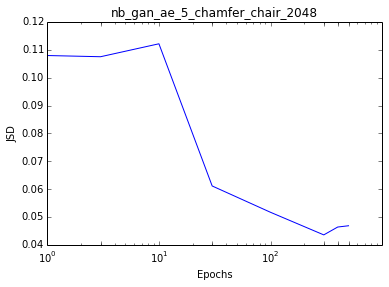

In [7]:
epochs = [1, 3, 10, 30, 100, 300, 400, 500]
# plt.plot(epochs, jsd_measurements)
plt.semilogx(epochs, jsd_measurements)
# # plt.xticksick_params(axis='x', which='both', bottom='off', top='off')
# # plt.tick_params(axis='y', which='both', left='off', right='off')
    
plt.xlabel('Epochs') 
plt.ylabel('JSD')
plt.title(nbgan_tag)
plt.xticks(epochs)

In [16]:
if cmp_raw_gan:
    rgan_tag = class_name + '_mlp_arch_raw_gan_' + str(n_pc_samples) + '_pts'
    top_in = osp.join('/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/our_synthetic_samples', rgan_tag)
                      
    rgan_jsd_measurements = []
    
    for epoch in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
        in_f = osp.join(top_in, 'epoch_' + str(epoch) + '.npz')
        our_data = np.load(in_f)
        our_data = our_data[our_data.keys()[0]]
        our_data = pclouds_centered_and_half_sphere(our_data)
        _, our_grid_var = entropy_of_occupancy_grid(our_data, voxel_resolution, in_sphere=cmp_in_sphere)
        jsd_epoch = jensen_shannon_divergence(our_grid_var, gt_grid_var)
        rgan_jsd_measurements.append(jsd_epoch)
        print 'R-GAN-JSD', epoch, jsd_epoch 

R-GAN-JSD 1200 0.393757199564


# Plotting data in grid

In [13]:
# top_fig_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/images/' + ae_tag + '_'
# top_fig_dir = create_dir(osp.join(top_fig_dir, ae_tag + 'epoch_50'))
# syn_data = our_data 
# # Fix above

# size = 100
# rids = np.random.choice(range(len(syn_data)), size=size, replace=False)
# plt.ioff()

# for i in range(size):
#     fig = Point_Cloud(syn_data[rids[i]]).plot(show=False, show_axis=False, azim=290, in_u_sphere=False, s=20);
#     fig.savefig(osp.join(top_fig_dir, 'sample_' +str(i)))
#     plt.close()

# file_names = glob.glob(top_fig_dir +'/*.png')
# stack_images_in_square_grid(file_names, save_file= osp.join(top_fig_dir, 'aggregate_samples.png'));
# plt.ion()

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':
